In [12]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

ACT_PATH  = "updated_activity_labels_2 (1).xlsx"
HORM_PATH = "hormones.xlsx"

Data Preprocessing

In [13]:
act = pd.read_excel(ACT_PATH)

act["date"] = pd.to_datetime(act["date"], errors="coerce")

# start = date + time_of_day
act["start"] = pd.to_datetime(
    act["date"].dt.strftime("%Y-%m-%d") + " " + act["time_of_day"].astype(str),
    errors="coerce"
)

act["minutes"] = pd.to_numeric(act["minutes"], errors="coerce")
act["end"] = act["start"] + pd.to_timedelta(act["minutes"], unit="m")

# CAT label from sampling_id (1 -> CAT01)
act["CAT"] = ("CAT" + act["sampling_id"].astype(str).str.zfill(2)).astype(str).str.strip()

# keep only usable rows
act = act.dropna(subset=["CAT", "start", "end", "activity_label"]).copy()
act["start"] = pd.to_datetime(act["start"], errors="coerce")
act["end"]   = pd.to_datetime(act["end"], errors="coerce")
act = act.dropna(subset=["start", "end"]).copy()
act=act.drop(columns=["sampling_id"])
act["activity_label"].value_counts(normalize=False)



activity_label
sit                  127
light_activity       102
stand                 51
lying                 25
moderate_activity     18
Name: count, dtype: int64

In [14]:
# =========================================================
# 2) Load HORMONES: read ALL sheets + concat
# =========================================================
sheets = pd.read_excel(HORM_PATH, sheet_name=None)

horm_list = []
for sheet_name, df in sheets.items():
    if not str(sheet_name).upper().startswith("CAT"):
        continue

    df = df.copy()
    # Drop any "Unnamed:*" columns immediately
    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed: 2")].copy()
    # Standardise first columns: assume first col is timestamp
    # and second col is CAT if present; otherwise fill with sheet name.
    if df.shape[1] < 1:
        continue
    # rename first column -> ts
    df = df.rename(columns={df.columns[0]: "ts"})
    # If there is a CAT column already, try to detect it; else use sheet_name

    df = df.rename(columns={df.columns[1]: "CAT"})
    df["CAT"]=sheet_name

    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df["CAT"] = df["CAT"].astype(str).str.strip()

    # If CAT is missing/blank in the sheet, fill from sheet name
    df.loc[df["CAT"].isin(["", "nan", "NaN"]), "CAT"] = sheet_name

    # drop rows with no timestamp
    df = df.dropna(subset=["ts"]).copy()

    horm_list.append(df)

horm = pd.concat(horm_list, ignore_index=True)

# Final nuke: remove any remaining Unnamed columns (just in case)
horm = horm.loc[:, ~horm.columns.astype(str).str.startswith("Unnamed")].copy()

print("CATs in act:", sorted(act["CAT"].unique()))
print("CATs in horm:", sorted(horm["CAT"].unique()))
print("Horm date range:", horm["ts"].min(), "to", horm["ts"].max())

CATs in act: ['CAT01', 'CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT06', 'CAT07', 'CAT09', 'CAT10', 'CAT11', 'CAT12', 'CAT13', 'CAT14', 'CAT15', 'CAT17', 'CAT18']
CATs in horm: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
Horm date range: 2023-08-17 10:01:00 to 2024-02-22 12:26:00


In [15]:
# =========================================================
# 3) Keep only overlapping CATs
# =========================================================
cats_common = sorted(set(act["CAT"].unique()).intersection(set(horm["CAT"].unique())))
print("Common CATs:", cats_common)

act  = act[act["CAT"].isin(cats_common)].copy()
horm = horm[horm["CAT"].isin(cats_common)].copy()

print("CATs in act:", sorted(act["CAT"].unique()))
print("CATs in horm:", sorted(horm["CAT"].unique()))

Common CATs: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
CATs in act: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']
CATs in horm: ['CAT02', 'CAT03', 'CAT04', 'CAT05', 'CAT11']


In [16]:
# =========================================================
# 4) Align hormones -> activities (per CAT, robust)
# =========================================================
out = []

for cat, hcat in horm.groupby("CAT", sort=False):
    acat = act[act["CAT"] == cat].copy()
    if len(acat) == 0 or len(hcat) == 0:
        continue

    acat = acat.sort_values("start").reset_index(drop=True)
    hcat = hcat.sort_values("ts").reset_index(drop=True)

    # Drop CAT so merge doesn't create CAT_x/CAT_y
    acat = acat.drop(columns=["CAT"], errors="ignore")
    hcat = hcat.drop(columns=["CAT"], errors="ignore")

    m = pd.merge_asof(
        hcat,
        acat,
        left_on="ts",
        right_on="start",
        direction="backward",
        allow_exact_matches=True
    )

    # keep only if ts is inside [start, end)
    m = m[m["ts"] < m["end"]].copy()
    m["CAT"] = cat

    out.append(m)

merged = pd.concat(out, ignore_index=True) if out else pd.DataFrame()
print("Aligned rows:", len(merged))
print("Aligned CATs:", sorted(merged["CAT"].unique()) if len(merged) else [])

# Drop any leftover Unnamed columns
merged = merged.loc[:, ~merged.columns.astype(str).str.startswith("Unnamed")].copy() 

Aligned rows: 102
Aligned CATs: ['CAT03', 'CAT04', 'CAT05', 'CAT11']


In [17]:
# =========================================================
# 5) Time features
# =========================================================
merged["hour"] = merged["ts"].dt.hour
merged["minute"] = merged["ts"].dt.minute
merged["tod_min"] = merged["hour"] * 60 + merged["minute"]
merged["tod_sin"] = np.sin(2 * np.pi * merged["tod_min"] / 1440.0)
merged["tod_cos"] = np.cos(2 * np.pi * merged["tod_min"] / 1440.0)

In [18]:
merged.columns = (
    merged.columns
        .astype(str)
        .str.strip()
        .str.lower()
)

In [19]:
# =========================================================
# 6) Fix rare classes (so stratify works)
# =========================================================
target = "activity_label"
min_count = 2  # minimum for stratify; set 5 for more stable learning

vc = merged[target].value_counts() #this creates dictionary
rare = vc[vc < min_count].index #index extracts their name of the rare
merged = merged[~merged[target].isin(rare)].copy()  #takes out the non rare ones
# merged[target]=merged[target].replace("light_activity","stand")
print("Class counts:\n", merged[target].value_counts())
print(merged.columns.values.tolist()) 

Class counts:
 activity_label
sit               51
stand             24
light_activity    15
lying             11
Name: count, dtype: int64
['ts', 'metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone', 'dopeg', 'cortisol', 'cortisone', 'date', 'activity_number', 'description', 'intensity', 'minutes', 'time_of_day', 'activity_label', 'start', 'end', 'cat', 'hour', 'minute', 'tod_min', 'tod_sin', 'tod_cos']


In [20]:
def collapse_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip().str.lower()

    new_cols = {}
    for name in pd.unique(df.columns):
        block = df.loc[:, df.columns == name]
        if block.shape[1] == 1:
            new_cols[name] = block.iloc[:, 0]
        else:
            new_cols[name] = block.bfill(axis=1).iloc[:, 0]  # coalesce duplicates

    return pd.DataFrame(new_cols, index=df.index)

merged = collapse_duplicate_columns(merged)

In [21]:
# =========================================================
# 7) Build X / y
# =========================================================
exclude = {
    "ts","date","time_of_day","start","end",
    "minutes","description","intensity","activity_number","hour" ,'minute', 'tod_min', 'tod_sin', 'tod_cos',
    target
}

feature_cols = [c for c in merged.columns if c not in exclude]

X = merged[feature_cols].copy()
print(X.columns.values.tolist())
y = merged[target].copy()

# One-hot CAT
X = pd.get_dummies(X, columns=["cat"], dummy_na=False) #because ML cant work with strings or just 1 3 4 5 2 might start using superior inferior instead of binary classification

# Drop fully empty cols
X = X.dropna(axis=1, how="all")

# =========================================================
# 8) Train XGBoost
# =========================================================
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, random_state=42, stratify=y_enc
)

model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Classes:", list(le.classes_))
print(classification_report(y_test, pred, target_names=le.classes_))

['metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone', 'cat']
Classes: ['light_activity', 'lying', 'sit', 'stand']
                precision    recall  f1-score   support

light_activity       0.00      0.00      0.00         4
         lying       0.50      0.67      0.57         3
           sit       0.69      0.85      0.76        13
         stand       1.00      0.83      0.91         6

      accuracy                           0.69        26
     macro avg       0.55      0.59      0.56        26
  weighted avg       0.63      0.69      0.66        26



['metanephrine', 'normetanephrine', '3-mt', 'noradrenaline', 'adrenaline', 'dopamine', 'ldopa', '3-omd', 'dopac', 'dopeg', 'melatonin', '18-oh-cortisol', 'cortisol', 'cortisone', 'cat_CAT04']


<Axes: >

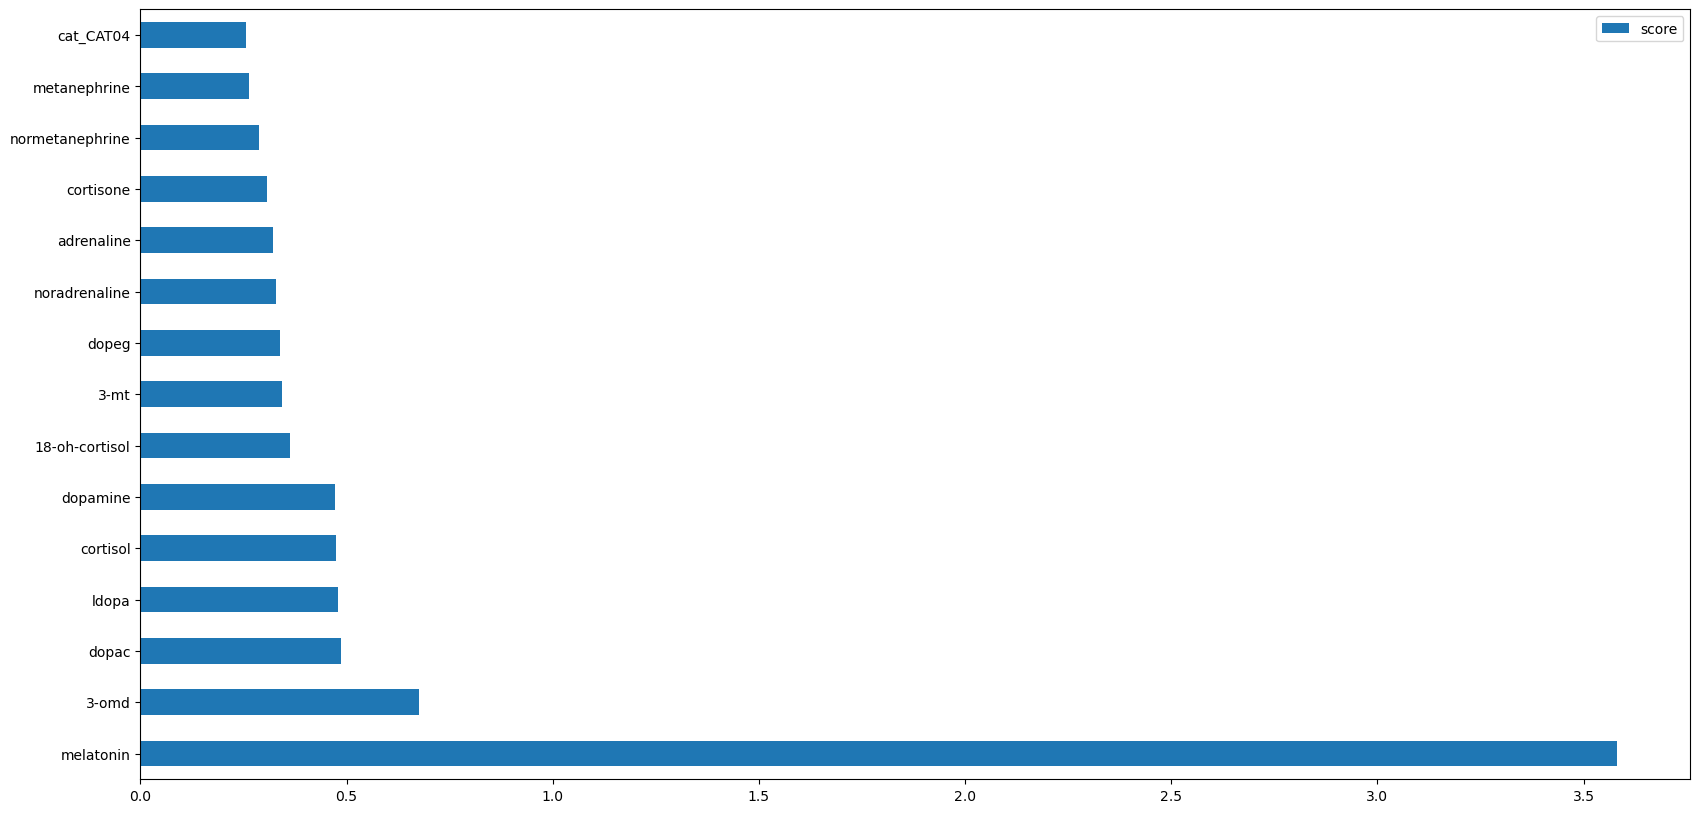

In [22]:
# Source - https://stackoverflow.com/a/52777909
# Posted by Chau Pham, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-30, License - CC BY-SA 4.0

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
print(keys)
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
